In [1]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
import shutil
import numpy as np
import torch.nn as nn
import torch
import torchvision.transforms as transforms
from torch import Generator
from torch.utils.data import Dataset, DataLoader, Subset, random_split, SubsetRandomSampler
from sklearn.model_selection import train_test_split
import pandas as pd


device = "cuda" if torch.cuda.is_available() else "cpu"

classes = ["1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18"]

class_mapping = {
    
    "01_Byzantin_Iconography": 0,
    "02_Early_Renaissance":1,
    "03_Northern_Renaissance":2,
    "04_High_Renaissance":3,
    "05_Baroque":4,
    "06_Rococo":5,
    "07_Romanticism":6,
    "08_Realism":7,
    "09_Impressionism":8,
    "10_Post_Impressionism":9,
    "11_Expressionism":10,
    "12_Symbolism":11,
    "13_Fauvism":12,
    "14_Cubism":13,
    "15_Surrealism":14,
    "16_AbstractArt":15,
    "17_NaiveArt":16,
    "18_PopArt" : 17
}

e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class DatasetPandora(Dataset):
    def __init__(self, excel_path):
        
        df = pd.read_excel(excel_path)

        self.data = df["paths"]
        self.labels = df["labels"]
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([64,64]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):

        img = cv2.imread(self.data[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = np.transpose(img, [2,0,1])

        batch_data = img
        batch_data = self.transf(batch_data)
        # batch_data = batch_data.to(self.device)


        batch_labels = self.labels[idx]
        # batch_labels = batch_labels.to(self.device)

        batch = {'data': batch_data, 'labels': batch_labels}

        return batch_data, batch_labels


In [3]:
dev = torch.device('cuda')
torch.cuda.empty_cache()
from torchvision import models, transforms


# torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

excel_train = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Pandora_18k_Merged\\training_paths_labels.xlsx"
excel_test = "E:\Lucru\ANUL II MASTER\MLAV\ProiectDificil\Pandora_18k_Merged\\testing_paths_labels.xlsx"

# mobile_net = models.alexnet(pretrained=True)
mobile_net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobile_net.to(device)
torch.backends.cudnn.benchmark = True

# mobile_net.load_state_dict(torch.load('mobileNet_PandoraTrain3.pt'))


# Training Param
# for param in mobile_net.parameters():
#     param.requires_grad = False

mobile_net.classifier[1] = nn.Linear(in_features=1280, out_features=18, bias=True)
# mobile_net.classifier[6] = nn.Linear(in_features=4096, out_features=18, bias=True)


loss_function = nn.CrossEntropyLoss(reduction="sum")
optim = torch.optim.AdamW(mobile_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer = optim, step_size = 10, gamma=0.1)

train_data_dataset = DatasetPandora(excel_train)
train_loader = DataLoader(train_data_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

nr_epoci = 50
mobile_net.train()
mobile_net.cuda()

model_losses = []
model_acc = []

## TRAIN ##

for epoca in range(nr_epoci):
    running_loss = 0.0
    running_corrects  = 0.0

    print(" --------  Start Epoca {}".format(epoca+1))
    for data, labels in train_loader:
        batch_data = data.to(torch.device('cuda'))
        labels = labels.to(torch.device('cuda'))

        outputs = mobile_net.forward(batch_data)
    
        loss = loss_function(outputs, labels)
        running_loss += loss.item()
        
        
        _, predictions = torch.max(outputs, 1)

        loss.backward()
        optim.step()
        optim.zero_grad()

        running_loss += loss.item() * 32
        running_corrects += torch.sum(predictions == labels)
        # print(running_loss)
    
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    scheduler.step()

    print("-- EPOCA {} ----  Acuratetea: {} - Loss: {}".format(epoca+1, epoch_acc * 100, epoch_loss))
    model_losses.append(epoch_loss)
    model_acc.append(epoch_acc)
    torch.save(mobile_net.state_dict(), '.\\mobileNet_PandoraTrain4.pt')

Using cache found in C:\Users\Teodora/.cache\torch\hub\pytorch_vision_v0.10.0
e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 --------  Start Epoca 1
-- EPOCA 1 ----  Acuratetea: 32.816941444002275 - Loss: 66.78588433561168
 --------  Start Epoca 2
-- EPOCA 2 ----  Acuratetea: 44.27231381466743 - Loss: 53.950061181108
 --------  Start Epoca 3
-- EPOCA 3 ----  Acuratetea: 51.08015918135303 - Loss: 47.41653939442854
 --------  Start Epoca 4
-- EPOCA 4 ----  Acuratetea: 56.978396816372936 - Loss: 41.55070280744109
 --------  Start Epoca 5
-- EPOCA 5 ----  Acuratetea: 61.476691301876066 - Loss: 37.4237654199649
 --------  Start Epoca 6
-- EPOCA 6 ----  Acuratetea: 66.23081296191017 - Loss: 32.38125324195051
 --------  Start Epoca 7
-- EPOCA 7 ----  Acuratetea: 70.29562251279135 - Loss: 28.40584555154771
 --------  Start Epoca 8
-- EPOCA 8 ----  Acuratetea: 73.7066515065378 - Loss: 25.36886588004992
 --------  Start Epoca 9
-- EPOCA 9 ----  Acuratetea: 78.09835133598635 - Loss: 21.25530441001168
 --------  Start Epoca 10
-- EPOCA 10 ----  Acuratetea: 80.46475270039795 - Loss: 19.267909033180572
 --------  Start E

KeyboardInterrupt: 

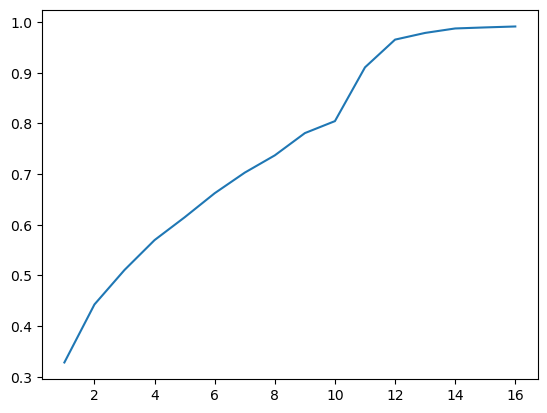

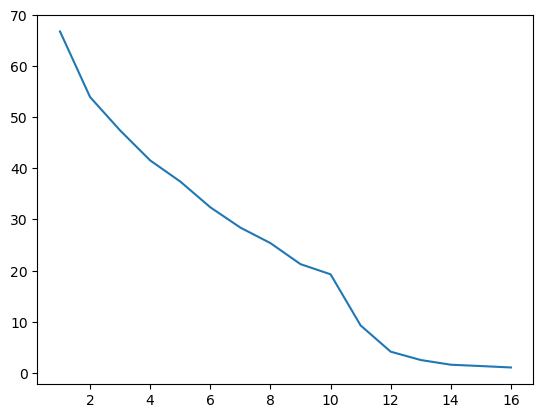

In [6]:
def my_plot(epochs, loss):
    plt.plot(epochs, loss)

new_model_acc = []
for model_acc_index in model_acc:
    new_model_acc.append(model_acc_index.to(torch.device('cpu')))


# new_model_loss = []
# for model_loss in model_losses:
#     # new_model_loss.append(model_loss.to(torch.device('cpu')))
#     model_loss.to(torch.device('cpu'))
# # my_plot(np.linspace(1, 20, 20).astype(int), model_acc.to(torch.device('cpu')))

plt.figure()
my_plot(np.linspace(1, 16, 16).astype(int), new_model_acc)

plt.figure()
my_plot(np.linspace(1, 16, 16).astype(int), model_losses)



# Testare

In [7]:
# test_data_dataset = DatasetPandora(test_data, test_labels)
# test_loader = DataLoader(train_data_dataset, batch_size=128, shuffle=True, num_workers=0)

test_data_dataset = DatasetPandora(excel_test)
test_loader = DataLoader(train_data_dataset, batch_size=128, shuffle=True, num_workers=0, pin_memory=True)

In [36]:
# for param in mobile_net.parameters():
#     param.requires_grad = False

# mobile_net.classifier[1] = nn.Linear(in_features=1280, out_features=18, bias=True)

# LOAD NET
# mobile_net.load_state_dict(torch.load('mobileNet_PandoraTrain2.pt'))
mobile_net.eval()
mobile_net.cuda()

predictii = []
real_labels = []
mobile_net.eval()

for batch in test_loader:
    batch_data, batch_targets = batch
    real_labels = np.concatenate([real_labels, batch_targets])


    batch_data = batch_data.to(torch.device('cuda'))
    batch_targets = batch_targets.to(torch.device('cuda'))
    batch_data.size()
    # batch_data = batch['date']
    # batch_labels = batch['etichete']


    current_predict = mobile_net.forward(batch_data)
    current_predict = current_predict.to(torch.device('cpu'))
    current_predict = np.argmax(current_predict.detach().numpy(),axis=1)
    predictii = np.concatenate((predictii,current_predict))


acc = np.sum(predictii==real_labels)/len(predictii)

precision = np.sum(predictii==real_labels) / ( np.sum(predictii!=real_labels) + np.sum(predictii==real_labels))
print( 'Acuratetea la test este {}%'.format(acc*100) )
print( 'Precizia la test este {}%'.format(precision*100) )

Acuratetea la test este 99.62336554860717%
Precizia la test este 99.62336554860717%


In [43]:
s = 0
for i, pred in enumerate(predictii):
    # print("pred: {}, real: {}".format(pred, real_labels[i]))
    if pred != real_labels[i] :
        print("pred: {}, real: {}".format(pred, real_labels[i]))
        s += 1

print(s)


pred: 14.0, real: 13.0
pred: 9.0, real: 12.0
pred: 9.0, real: 12.0
pred: 15.0, real: 10.0
pred: 12.0, real: 10.0
pred: 13.0, real: 16.0
pred: 15.0, real: 11.0
pred: 11.0, real: 10.0
pred: 10.0, real: 12.0
pred: 12.0, real: 13.0
pred: 12.0, real: 10.0
pred: 2.0, real: 4.0
pred: 15.0, real: 13.0
pred: 2.0, real: 4.0
pred: 12.0, real: 9.0
pred: 7.0, real: 9.0
pred: 13.0, real: 14.0
pred: 9.0, real: 8.0
pred: 9.0, real: 11.0
pred: 9.0, real: 12.0
pred: 12.0, real: 9.0
pred: 10.0, real: 12.0
pred: 9.0, real: 16.0
pred: 13.0, real: 12.0
pred: 11.0, real: 10.0
pred: 10.0, real: 11.0
pred: 14.0, real: 13.0
pred: 12.0, real: 10.0
pred: 9.0, real: 12.0
pred: 13.0, real: 14.0
pred: 15.0, real: 10.0
pred: 9.0, real: 12.0
pred: 15.0, real: 13.0
pred: 11.0, real: 6.0
pred: 17.0, real: 14.0
pred: 9.0, real: 12.0
pred: 10.0, real: 15.0
pred: 11.0, real: 10.0
pred: 13.0, real: 12.0
pred: 11.0, real: 10.0
pred: 9.0, real: 12.0
pred: 12.0, real: 9.0
pred: 12.0, real: 10.0
pred: 15.0, real: 10.0
pred: 12.

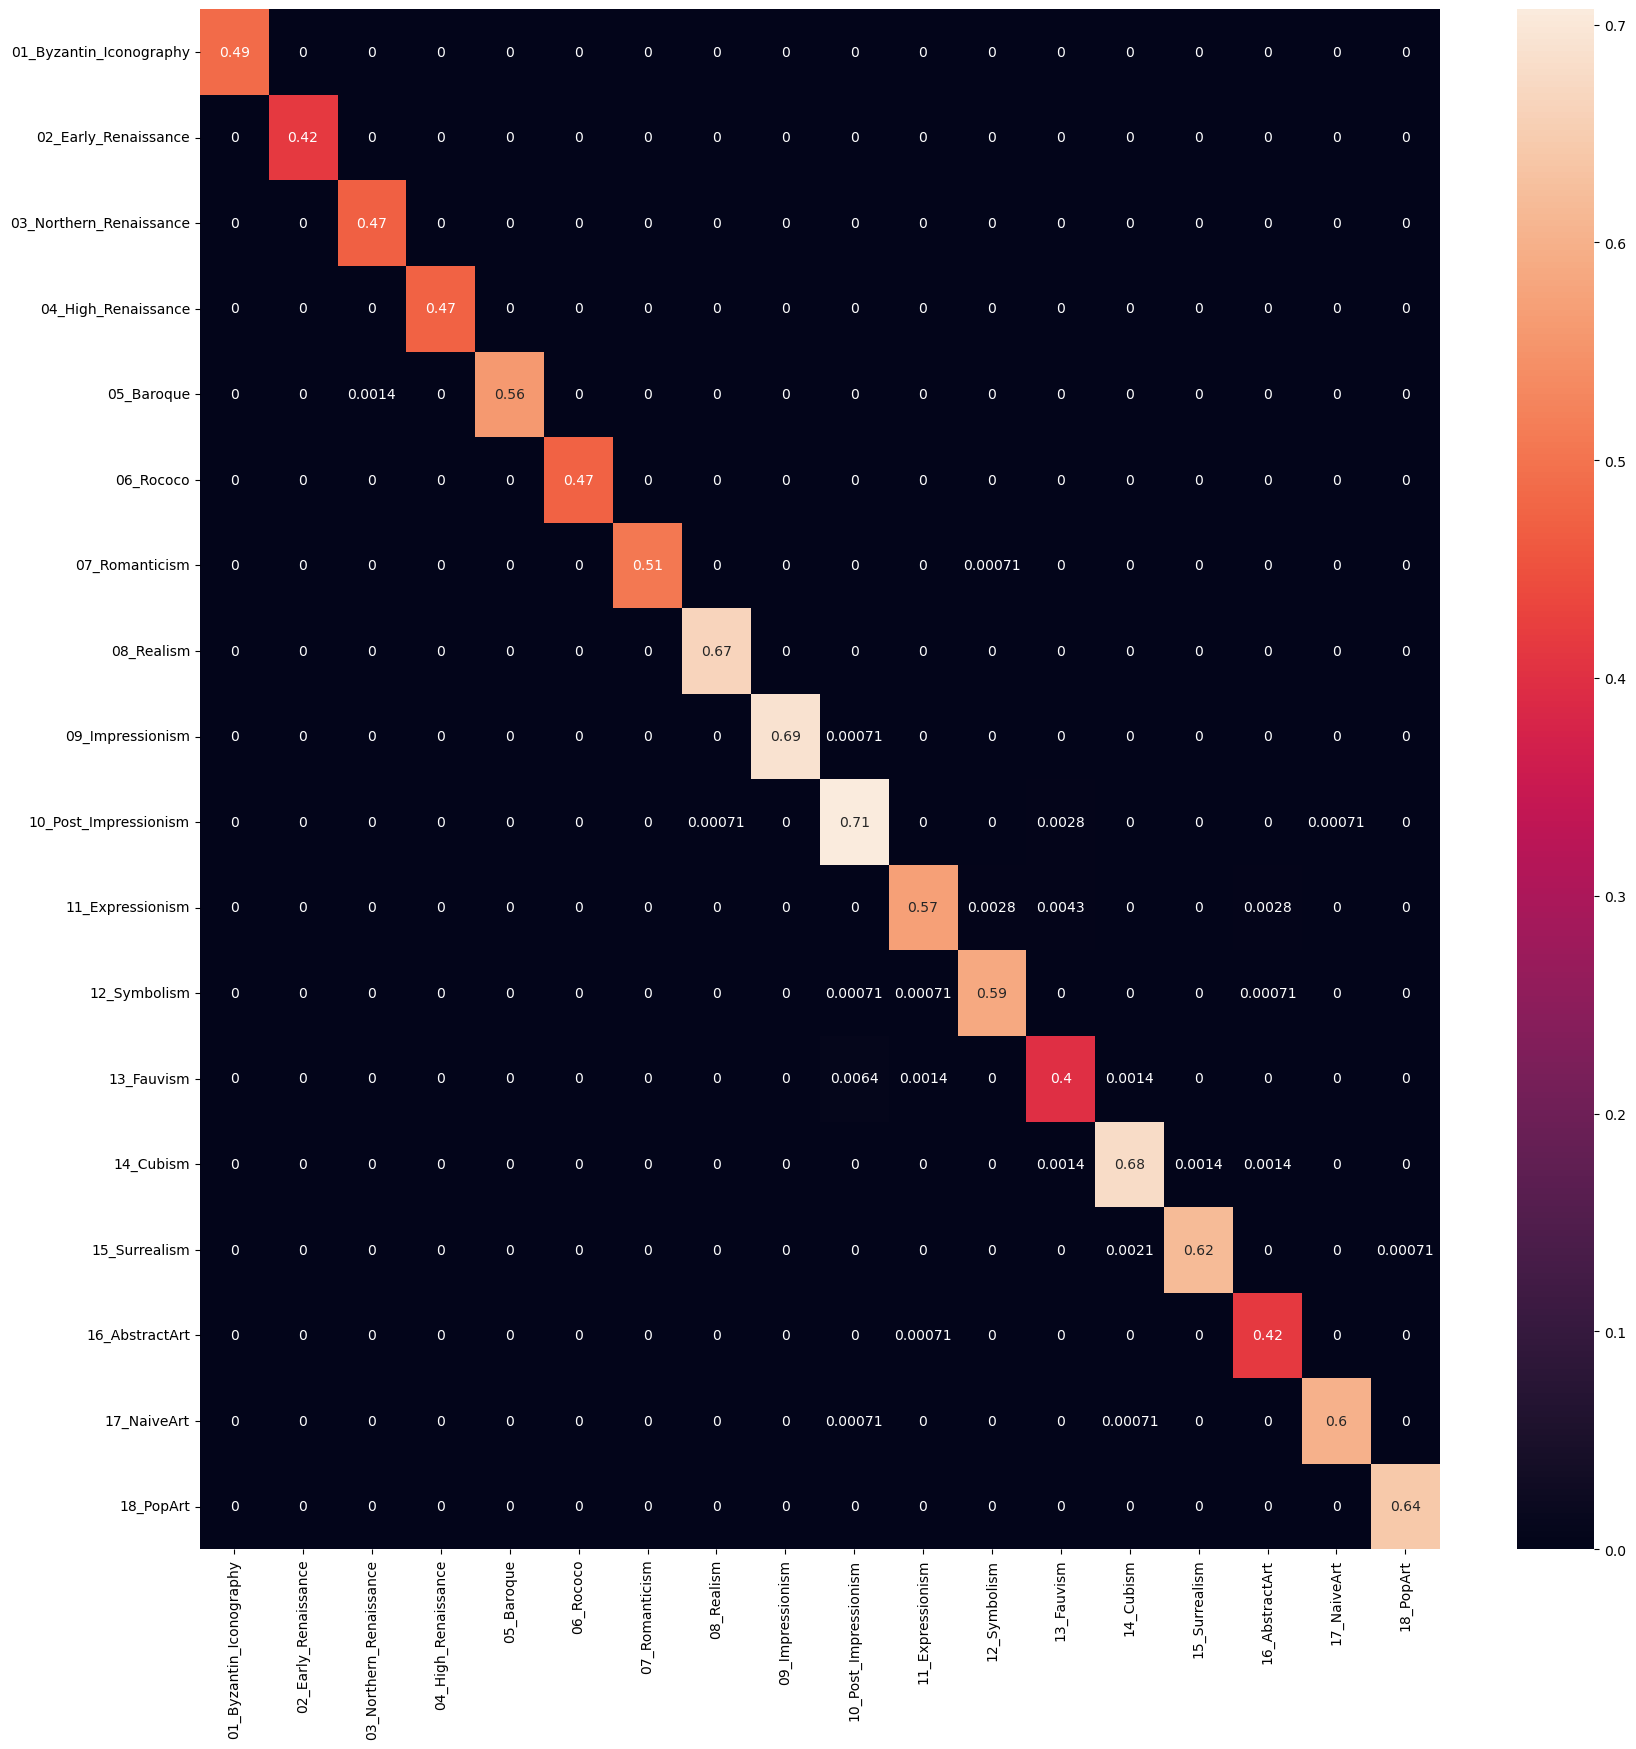

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd


y_pred = predictii
y_true = real_labels

cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_mapping],
                     columns = [i for i in class_mapping])
plt.figure(figsize = (20,20))
sn.heatmap(df_cm, annot=True)
# plt.savefig('output.png')
plt.show()

In [11]:
mobile_net = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobile_net.to(device)

for param in mobile_net.parameters():
    param.requires_grad = False

mobile_net.classifier[1] = nn.Linear(in_features=1280, out_features=18, bias=True)

# LOAD NET
mobile_net.load_state_dict(torch.load('mobileNet_PandoraTrain4.pt'))
mobile_net.cuda()
mobile_net.eval()

Using cache found in C:\Users\Teodora/.cache\torch\hub\pytorch_vision_v0.10.0
e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
e:\Programe\Anaconda\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Real label: 13_Fauvism
tensor([-1.8969, -3.1002, -5.0008, -5.8644, -8.8841, -5.5157, -8.7142, -5.6781,
        -3.3394,  3.7030, -2.1238, -1.7407,  3.9770, -2.6359, -3.1048, -2.0267,
        -0.8393,  3.0813], grad_fn=<SelectBackward0>)
tensor([1.2831e-03, 3.8517e-04, 5.7576e-05, 2.4276e-05, 1.1850e-06, 3.4405e-05,
        1.4045e-06, 2.9247e-05, 3.0323e-04, 3.4695e-01, 1.0226e-03, 1.4999e-03,
        4.5627e-01, 6.1278e-04, 3.8341e-04, 1.1268e-03, 3.6944e-03, 1.8632e-01],
       grad_fn=<SoftmaxBackward0>)
tensor(3.9770, grad_fn=<SelectBackward0>)
Predicted label:  13_Fauvism


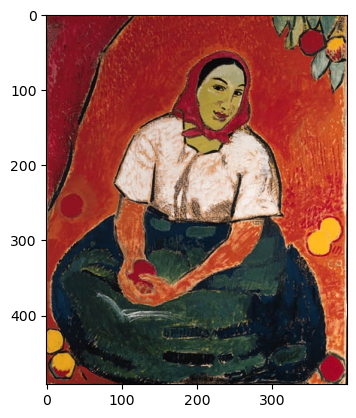

In [51]:
inv_map = {v: k for k, v in class_mapping.items()}


transf = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

picture = 4

# test_img = cv2.imread(train_data[picture])
# test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

hardcode_picture_path = "E:\\Lucru\\ANUL II MASTER\\MLAV\\ProiectDificil\\Pandora_18k_Merged\\13_Fauvism\\Fauvism (33).jpg"
hardcode_label = "13_Fauvism"
hardcode_trigger = 1

img = cv2.imread(hardcode_picture_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(img)
print("Real label:", hardcode_label)

data = transf(img)
data = data.to(torch.device('cuda'))
data = data[None, :]
# data.size()
# test_label = test_labels[picture].to(torch.device('cuda'))


predict = mobile_net(data)
predict = predict.to(torch.device('cpu'))

print(predict[0])
probabilities = torch.nn.functional.softmax(predict[0], dim=0)
print(probabilities)

probabilities = probabilities.to(torch.device('cpu'))

best_outcome = np.argmax(predict.detach().numpy())
print(predict[0][best_outcome])
print("Predicted label: ",inv_map[best_outcome])
